# Instação de pacotes externos

In [1]:
!pip install bitstring

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Código auxiliar

In [2]:
import pickle
import numpy as np

from itertools import product
from bitstring import BitArray, Bits, BitStream


class MyImgFormat:
    def __init__(self, mat_rgb_ids, rgb_ids_dict):
        self.im_shape_      = mat_rgb_ids.shape
        self.rgb_ids_dict_  = rgb_ids_dict
        self.num_bits_uint_ = int(np.ceil(np.log2(len(rgb_ids_dict))))
        
        self._mat2bytes(mat_rgb_ids)
        
    def _mat2bytes(self, mat):
        self.pixel_bytes_: BitStream = BitStream()
        
        pixel_rgb_ids = mat.reshape(-1)
        for rgb_id in pixel_rgb_ids:
            self.pixel_bytes_.append(
                Bits(uint=int(rgb_id), 
                     length=self.num_bits_uint_)
                )
        
    def unpack(self):
        # unpack IDs
        cp_bits = self.pixel_bytes_.copy()
        num_ids = cp_bits.len // self.num_bits_uint_
        
        mat_ids = np.array([
            cp_bits.read('uint:%d' % (self.num_bits_uint_))\
            for i in range(num_ids)\
        ]).reshape(self.im_shape_)
        
        # unpack RGB
        im_rgb = np.zeros(
            (self.im_shape_[0], self.im_shape_[1], 3), 
            dtype='uint8'
            )
        for i in range(self.im_shape_[0]):
            for j in range(self.im_shape_[1]):
                im_rgb[i, j, :] = self.rgb_ids_dict_[mat_ids[i, j]]
                
        return im_rgb

def uniform_quant(im, n_colors):
    # numero de cores e espaco entre as cores (lagura do bin)
    n_vals_ch  = int(np.cbrt(n_colors))
    bin_size   = 256 // n_vals_ch
    
    # possiveis valores por canal e por pixel (combinacao dos 3 canais)
    ch_vals    = np.uint8((np.arange(n_vals_ch)) * bin_size)
    pixel_vals = list(product(ch_vals, ch_vals, ch_vals))
    
    im_qt_rgb  = im // bin_size
    im_qt_rgb[im_qt_rgb >= n_vals_ch] = n_vals_ch - 1
    im_qt_rgb  = np.uint8((im_qt_rgb) * bin_size)
    
    # criar os dicionarios ID -> pixel e pixel -> ID
    dict_id2pixel = {i: list(pixel_vals[i]) for i in range(len(pixel_vals))}
    dict_pixel2id = {pixel_vals[i]: i for i in range(len(pixel_vals))}
    
    mat_ids = np.zeros((im.shape[0], im.shape[1]), dtype='uint8')
    for i in range(im.shape[0]):
        for j in range(im.shape[1]):
            mat_ids[i, j] = dict_pixel2id[tuple(im_qt_rgb[i, j])]
    
    return mat_ids, dict_id2pixel


def get_bin_size_kb(obj):
    return len(pickle.dumps(obj)) / 1e3

# Início do código elaborado

## Questão 1

### Setup

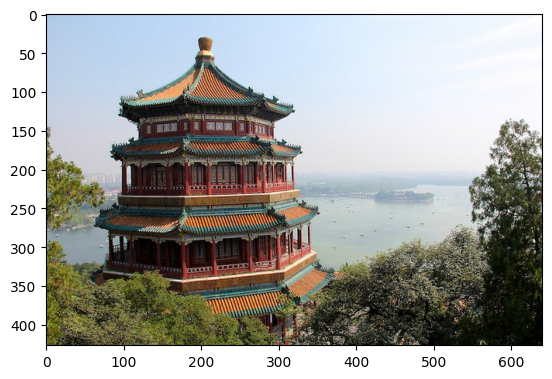

In [3]:
from sklearn.datasets import load_sample_image
import matplotlib.pyplot as plt

# Carrega imagem `china.jpg`
china = load_sample_image('china.jpg')
plt.imshow(china)
plt.show()

### 1a

In [4]:
def uniform_quant_2(im, n_colors):
    # numero de cores e espaco entre as cores (lagura do bin)
    n_vals_ch  = int(np.cbrt(n_colors))
    bin_size   = 256 // n_vals_ch

    # possiveis valores por canal e por pixel (combinacao dos 3 canais)
    ch_vals    = np.uint8((np.arange(n_vals_ch)) * bin_size)
    pixel_vals = list(product(ch_vals, ch_vals, ch_vals))

    im_qt_rgb  = im // bin_size
    im_qt_rgb[im_qt_rgb >= n_vals_ch] = n_vals_ch - 1
    im_qt_rgb  = np.uint8((im_qt_rgb) * bin_size)

    # criar os dicionarios ID -> pixel e pixel -> ID
    # DIVIDE O VALOR RGB PELA METADE NO DICT DE DADOS
    dict_id2pixel = {i: list([v//2 for v in pixel_vals[i]]) for i in range(len(pixel_vals))}
    dict_pixel2id = {pixel_vals[i]: i for i in range(len(pixel_vals))}

    mat_ids = np.zeros((im.shape[0], im.shape[1]), dtype='uint8')
    for i in range(im.shape[0]):
        for j in range(im.shape[1]):
            mat_ids[i, j] = dict_pixel2id[tuple(im_qt_rgb[i, j])]

    return mat_ids, dict_id2pixel

Reduzimos os valores quantizados pela metade na linha 16

### 1b

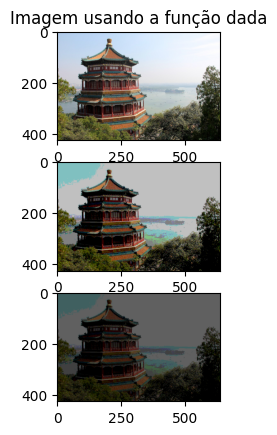

In [5]:
# Cria 3 subplots, um para cada imagem da figura f
f, subf = plt.subplots(3, 1)

# Ecibe imagem original
subf[0].set_title("Imagem original")
subf[0].imshow(china)

# Carrega matriz de 'labels' e dicionário de cores
m2, d2 = uniform_quant(china, 2**6)
# Cria matriz cópia com cada label transformada em seu valor no dict
im2: MyImgFormat = MyImgFormat(m2, d2)
subf[0].set_title("Imagem usando a função dada")
subf[1].imshow(im2.unpack())

# Realiza o processo anterior com a função modificada
m3, d3 = uniform_quant_2(china, 2**6)
im3: MyImgFormat = MyImgFormat(m3, d3)
subf[2].imshow(im3.unpack())

# Exibe imagens
f.show()

Podemos ver a redução na saturação das cores ao escalarmos as cores quantizadas.

### 1c

In [6]:
print("Tamanhos das imagens:")
print("\tImagem original:", get_bin_size_kb(np.array(china)))
print("\tImagem quantizada original:", get_bin_size_kb(MyImgFormat(m2, d2).pixel_bytes_.bytes))
print("\tImagem quantizada modificada:", get_bin_size_kb(MyImgFormat(m3, d3).pixel_bytes_.bytes))

Tamanhos das imagens:
	Imagem original: 820.005
	Imagem quantizada original: 204.969
	Imagem quantizada modificada: 204.969


Como esperávamos, a imagem quantizada ocupa menos espaço, sendo que o valor do intervalo, como armazenado pelo mesmo tipo de variável, não impacta o tamanho final da imagem.

## Questão 2

### Setup

In [7]:
# Importando o algoritmo a usar
from sklearn.cluster import KMeans

# Import para documentação
from typing import List, Tuple

### 2a

In [8]:
def kmeansQuant(img: np.uint8, cluster: int = 64) -> Tuple[np.uint8, KMeans]:
    """
    Calcula centróides para o número dado de clusters e aproxima cada
    pixel da imagem dada para o centróide de seu cluster.

    Parameters:
    ----------
    img: np.uint8
        Imagem carregada como array numpy de uint8
    cluster: int
        Número de clusters para cálculo

    Returns:
    ----------
    np.uint8
        Imagem recontruída em seu tamanho original com a aproximação de cada
        pixel a seu cluster correspondente
    KMeans
        Classe do algoritmo com seus hiper parâmetros
    """
    # Transforma tamanho e normaliza array de pixels carregado
    imgArray = np.reshape(img, (-1, 3)) / 255
    # Treina classificador k-means com parâmetros dados sobre o array gerado
    km = KMeans(n_clusters=cluster, random_state=42, max_iter=10, n_init="auto").fit(imgArray)
    # Prediz 'labels' dentre os centróides calculados em todos os pixels da matriz
    labels = km.predict(imgArray)
    # Transforma cada pixel no centróide previsto pelo algoritmo e
    # retoma o tamanho original da imagem
    return np.reshape(km.cluster_centers_[labels], img.shape), km

### 2b

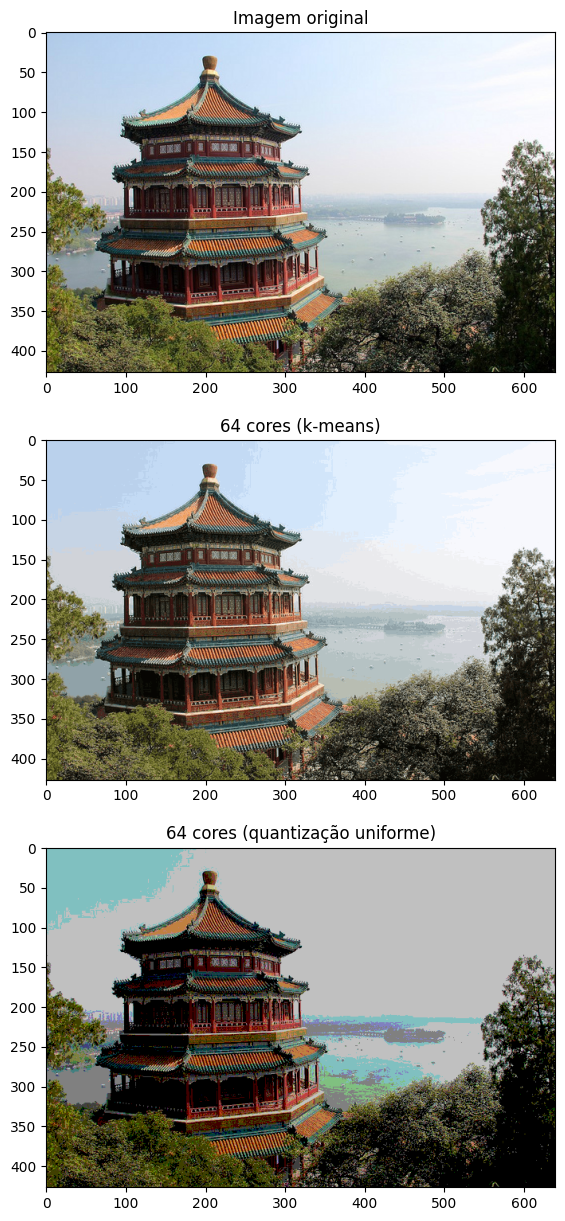

In [9]:
#  Cria 3 subplots para as imagens na figura f
f, subf = plt.subplots(3, 1, figsize=(15, 15))

subf[0].set_title("Imagem original")
subf[0].imshow(china)
subf[1].set_title("64 cores (k-means)")
subf[1].imshow(kmeansQuant(china)[0])
subf[2].set_title("64 cores (quantização uniforme)")
subf[2].imshow(im2.unpack())

f.show()

Podemos observar uma perda de detalhes muito mais brusca na quantização uniforme, já que, ao estabelecer um dicionário restrito de cores sem a influência da imagem orignal, sub utiliza e super utiliza uma pequena gama de tons. 

A quantização k-means cria mais clusters em áreas com mais informação, assim usando de forma mais performática as classificações que são realmente estabelecidas.

## Questão 3

### 3a

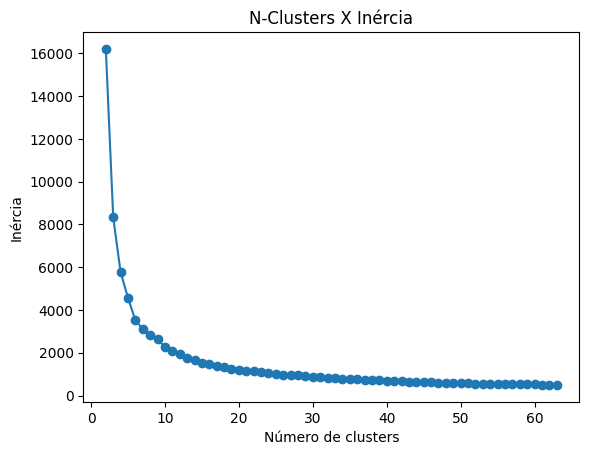

In [10]:
# Quantidades de cluster para teste
nTest = range(2, 64)
# Lista de inércias computadas
inertias: List[float] = []
# Imagem convertida temporária para cálculo
_china = np.reshape(china, (-1, 3)) / 255
# Para cada número de clusters
for i in nTest:
    # Encontra os hiper parâmetros para os clusters dados
    km = KMeans(n_clusters=i, random_state=42, max_iter=10, n_init="auto").fit(_china)
    # Salva a inércia correlata ao número de clusters
    inertias.append(km.inertia_)

plt.plot(nTest, inertias)
plt.scatter(nTest, inertias)

plt.xlabel("Número de clusters")
plt.ylabel("Inércia")
plt.title("N-Clusters X Inércia")

f.show()

Podemos ver a diminuição nos ganhos em inércia com o incremento do número de clusters e, observando pela heurística do 'método do cotovelo, temos um valor ótimo para o número de clusters em **n_clusters = 17**.

### 3b

In [11]:
# Tomando 17 como o número ótimo de clusters pelo 'método do cotovelo'
chinaQnt = kmeansQuant(china, 17)[0]
mse = (((china / 255) - chinaQnt)**2).mean()
print("MSE:", mse)

MSE: 0.0016884196895932777


## Questão 4

### Setup

In [12]:
flower = load_sample_image('flower.jpg')

# Número de cores para cálculo
quants = [ 8, 27, 64, 125, 216 ]

# Informações de cada uma das imagens
chinaQuants = {
    'img': china,
    'km': {},
    'unif': {},
}
flowerQuants = {
    'img': flower,
    'km': {},
    'unif': {},
}

### 4a

In [13]:
# Para cada imagem
for imgDict in [ chinaQuants, flowerQuants ]:
    # Para cada quantidade de cores
    for q in quants:
        # Calcula a quantização uniforme e k-means
        imgDict['km'][q] = kmeansQuant(imgDict['img'], q)
        imgDict['unif'][q] = MyImgFormat(*uniform_quant(imgDict['img'], q))

### 4b

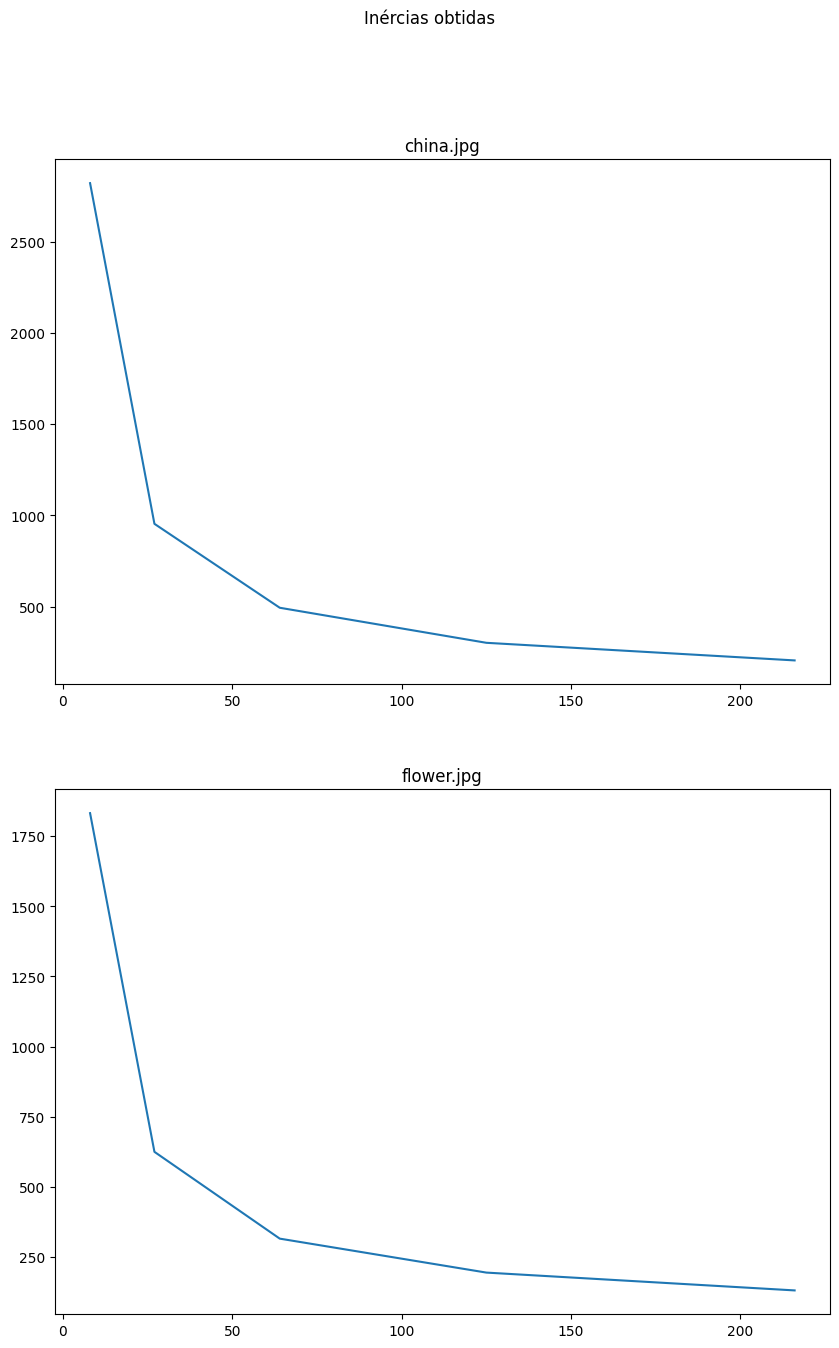

In [14]:
f, subf = plt.subplots(2, 1, figsize=(10, 15))
f.suptitle("Inércias obtidas")

subf[0].set_title("china.jpg")
subf[0].plot(quants, [chinaQuants['km'][i][1].inertia_ for i in quants])
subf[1].set_title("flower.jpg")
subf[1].plot(quants, [flowerQuants['km'][i][1].inertia_ for i in quants])

f.show()

Como esperado, com o aumento do número de clusters temos uma diminução na inércia do conjunto, porém com uma diminuição incremental na taxa de melhora.

### 4c

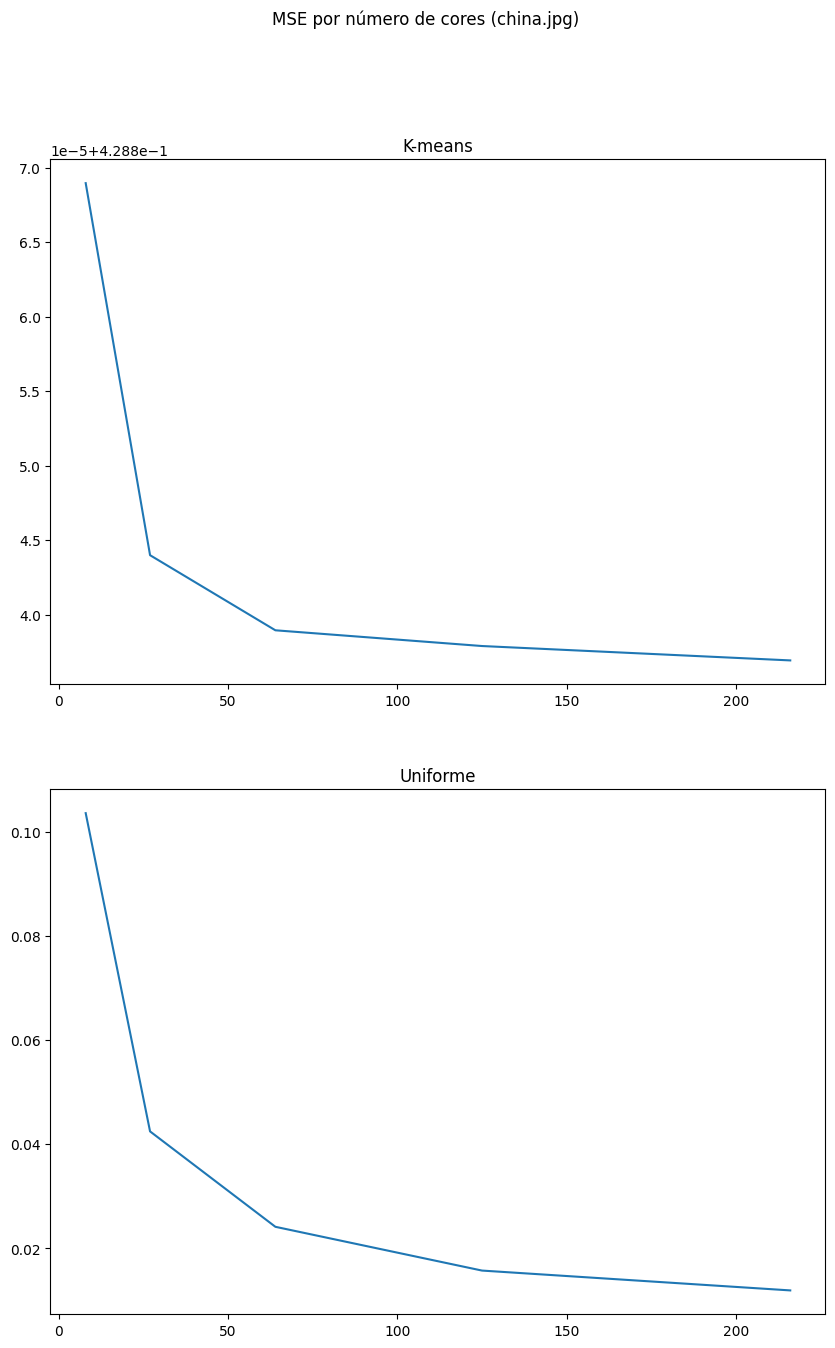

In [15]:
# Cálculos para 'china.jpg'
f, subf = plt.subplots(2, 1, figsize=(10, 15))
f.suptitle("MSE por número de cores (china.jpg)")

subf[0].set_title("K-means")
subf[0].plot(
    quants,
    [
        # Calcula o MSE com a imagem gerada com quantização k-means
        ((np.reshape(chinaQuants['km'][i][0]/255, china.shape) - (china / 255))**2).mean()
        for i in quants
    ]
)
subf[1].set_title("Uniforme")
subf[1].plot(
    quants,
    [
        # Calcula o MSE com a imagem gerada com quantização uniforme
        ((np.reshape(np.array(chinaQuants['unif'][i].unpack())/255, china.shape) - chinaQnt)**2).mean()
        for i in quants
    ]
)

f.show()

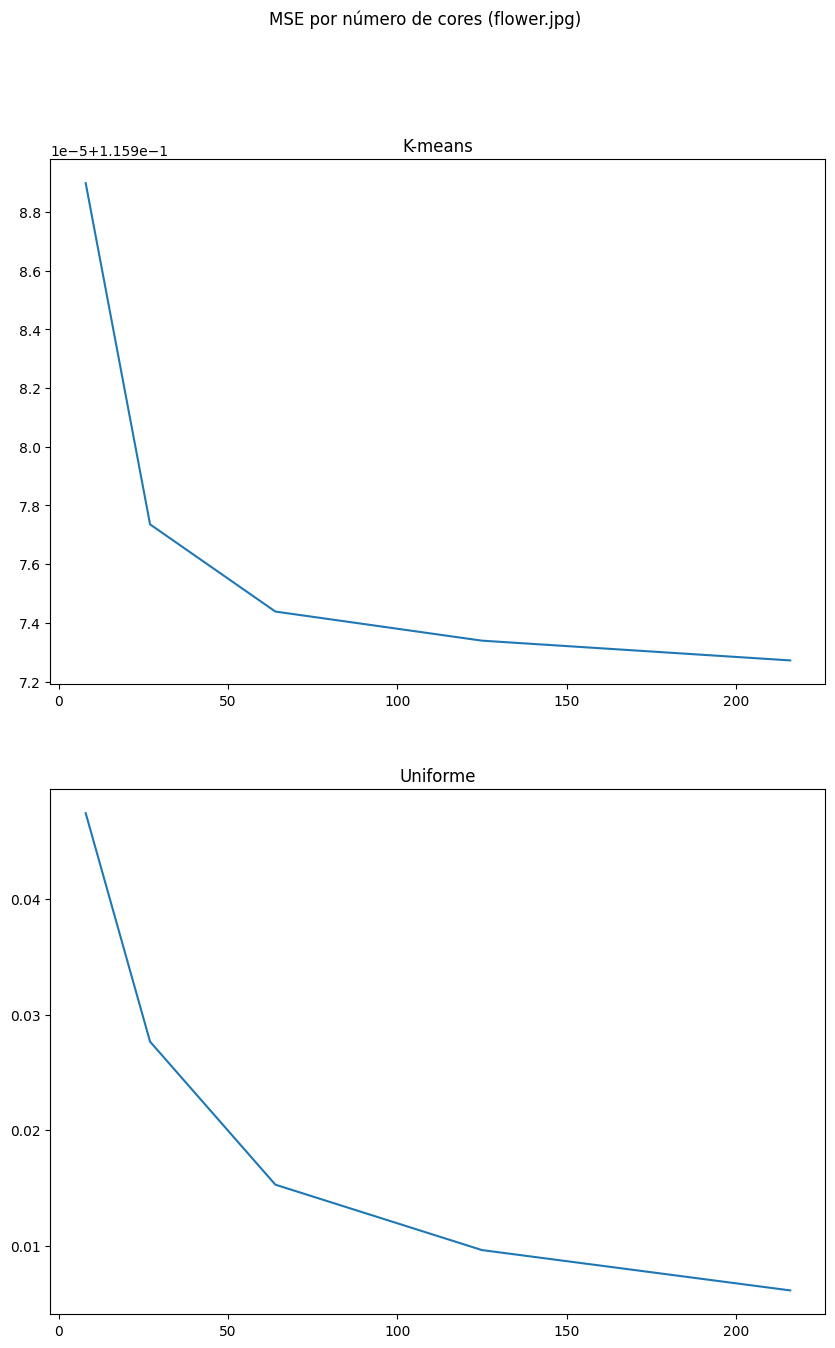

In [16]:
# Realiza o mesmo processo para 'flower.jpg'
f, subf = plt.subplots(2, 1, figsize=(10, 15))
f.suptitle("MSE por número de cores (flower.jpg)")

subf[0].set_title("K-means")
subf[0].plot(
    quants,
    [
        ((np.reshape(flowerQuants['km'][i][0]/255, flower.shape) - (flower / 255))**2).mean()
        for i in quants
    ]
)
subf[1].set_title("Uniforme")
subf[1].plot(
    quants,
    [
        ((np.reshape(np.array(flowerQuants['unif'][i].unpack())/255, flower.shape) - (flower / 255))**2).mean()
        for i in quants
    ]
)

f.show()

Assim como visto com a inércia no item anterior, o erro da imagem gerada diminui com o aumento do número de cores porém a taxa de diminuição também tende a diminuir.

### 4d

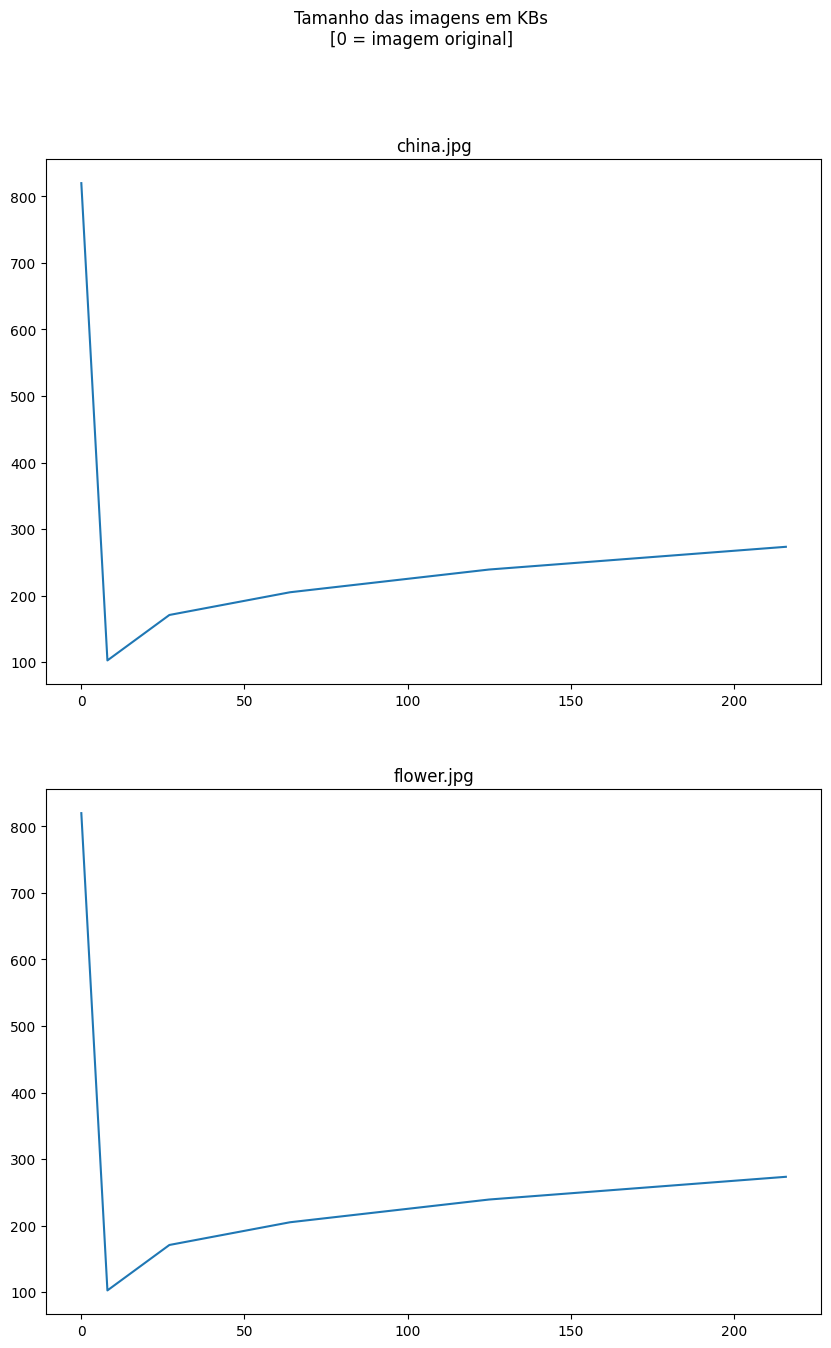

In [17]:
f, subf = plt.subplots(2, 1, figsize=(10, 15))
f.suptitle("Tamanho das imagens em KBs\n[0 = imagem original]")

subf[0].set_title("china.jpg")
subf[0].plot(
    [0, *quants],
    [
        get_bin_size_kb(np.array(china)),
        *[
            get_bin_size_kb(chinaQuants['unif'][i].pixel_bytes_.bytes)
            for i in quants
        ]
    ]
)
subf[1].set_title("flower.jpg")
subf[1].plot(
    [0, *quants],
    [
        get_bin_size_kb(np.array(flower)),
        *[
            get_bin_size_kb(flowerQuants['unif'][i].pixel_bytes_.bytes)
            for i in quants
        ]
    ]
)

f.show()

Temos uma diminuição do tamanho dos dados quando aplicado o algoritmo pela compressão dos dados pelo uso do dicionário de cores, com o aumento de entradas no dicionário de cores aumentando gradualmente o tamanho dos dados gerados porém mesmo com 256 cores se mantendo bem abaixo do tamanho original da imagem.